## Students Names & ID

HARISOA Anja Ny Aina 20180461
 
 Mareh AboGhanem     20190682

Esraa Ehsan Mohamed Saif  20190678

In [ ]:
import os
import re
import cv2 
from tqdm import tqdm
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout

##Upload data from kaggle

In [ ]:
'''from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/dataset/GrayToRGB.zip'''

"from google.colab import drive\ndrive.mount('/content/gdrive')\n!unzip gdrive/MyDrive/dataset/GrayToRGB.zip"

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

 99% 190M/192M [00:10<00:00, 23.0MB/s]
100% 192M/192M [00:10<00:00, 19.5MB/s]


In [ ]:
! unzip landscape-image-colorization

##Preprossing Dataset

In [ ]:
# To get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)   

In [ ]:
# defining the size of the image (128*128)
SIZE = 128 

#store colored img and reshape to 128

In [ ]:
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '2000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))

 28%|██▊       | 2000/7129 [00:01<00:03, 1392.12it/s]


#store gary img and reshape to 128

In [ ]:
gray_img = []
path = '/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '2000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 28%|██▊       | 2000/7129 [00:01<00:02, 1928.49it/s]


#plot gray and colored image before training

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 10)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Gray Image ', color = 'black', fontsize = 10)
    plt.imshow(grayscale)
   
    plt.show()

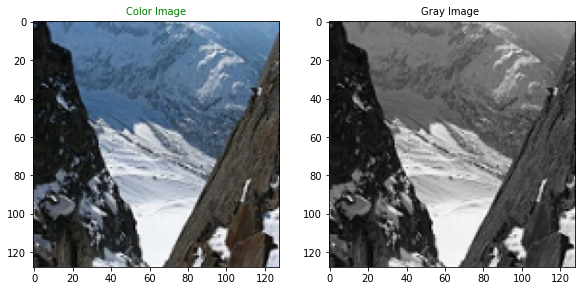

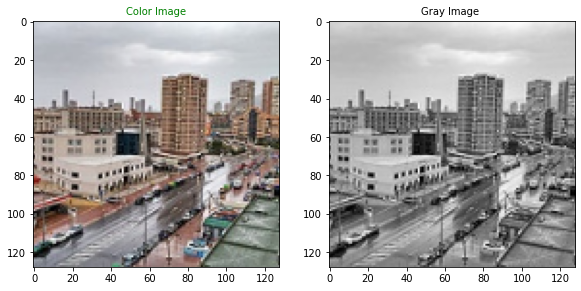

In [ ]:
for i in range(10,12):
     plot_images(color_img[i],gray_img[i])

#split to train and test

In [ ]:
# reshaping train dataset
train_gray = gray_img[1000:]
train_color = color_img[1000:]
train_g = np.reshape(train_gray,  (len(train_gray),SIZE,SIZE,3))
train_c = np.reshape(train_color, (len(train_color),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)

Train color image shape: (1000, 128, 128, 3)


In [ ]:
# reshaping test dataset
test_gray = gray_img[:200]
test_color = color_img[:200]
test_g  = np.reshape(test_gray, (len(test_gray),SIZE,SIZE,3))
test_c = np.reshape(test_color, (len(test_color),SIZE,SIZE,3))
print('Test color image shape',test_c.shape)

Test color image shape (200, 128, 128, 3)


## Model


1.  down smplaing function
2.  up smplaing function





In [ ]:
#function to down smplaing and apply conv2D filter
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [ ]:
#function to up smplaing using Conv2DTranspose
def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [128,128,3])
    #Down Sampling
    d1 = down(16,(3,3),False)(inputs)
    d2 = down(32,(3,3),False)(d1)
    d3 = down(32,(3,3),True)(d2)
    d4 = down(64,(3,3),True)(d3)
    d5 = down(64,(3,3),True)(d4)
    #Up Sampling
    u1 = up(64,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(32,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(32,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(16,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 32)   4640        ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 32)   9376        ['sequential_1[0][0]']       

#Compile and train Model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['acc'])
model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 0)

In [ ]:
model.evaluate(test_g,test_c)

7/7 [==============================] - 1s 28ms/step - loss: 0.0534 - acc: 0.4592


[0.05344248190522194, 0.45922791957855225]

### plot gray and colored image after training

1/1 [==============================] - 1s 606ms/step


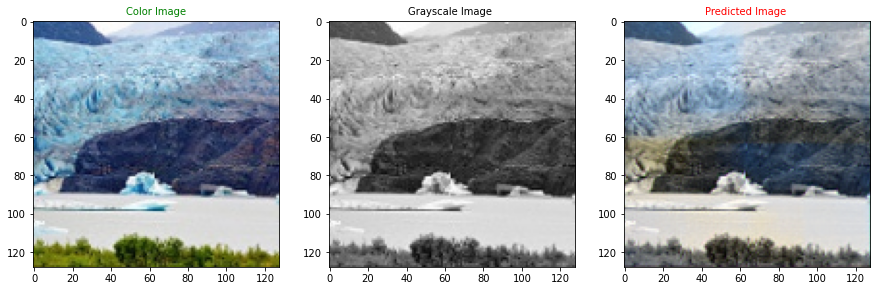

1/1 [==============================] - 0s 66ms/step


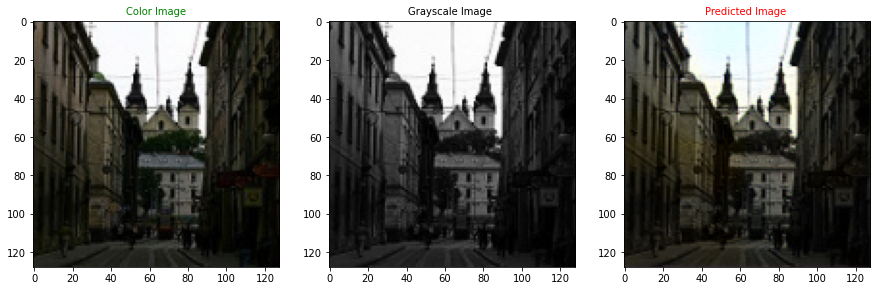

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 10)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 10)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 10)
    plt.imshow(predicted)
    plt.show()

for i in range(50,52):
    predicted = np.clip(model.predict(test_g[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_c[i],test_g[i],predicted)